In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spectral_analysis as sa
from math import floor

class spectrum:

    def __init__(self, X, Y, x_type, y_type):

        if x_type not in ["time", "freq", "wl"]:
            raise Exception("x_type must be either \"time\" or \"freq\" or \"wl\".")
        if y_type not in ["phase", "intensity"]:
            raise Exception("y_type must be either \"phase\" or \"intensity\".")

        self.X = X
        self.Y = Y
        self.unit = x_type
        self.type = y_type

class light:

    def __init__(self, vertical_polarization, horizontal_polarization):
        self.ver = vertical_polarization
        self.hor = horizontal_polarization

    def mix(self, M):
        ver = M[0, 0]*self.ver.values[:,1] + M[0,1]*self.hor.values[:,1]
        hor = M[0, 1]*self.ver.values[:,1] + M[1,1]*self.hor.values[:,1]
        self.ver.values[:, 1] = ver
        self.hor.values[:, 1] = hor

    def loss(self, fraction):
        self.ver.values[:, 1] *= (1-fraction)
        self.hor.values[:, 1] *= (1-fraction)

    def delay(self, polarization, delay):
        
        if polarization not in ["ver", "hor"]:
            raise Exception("Polarization must be either \"ver\" or \"hor\".")

        if polarization == "ver":
            self.ver.values[:, 1] *= np.exp(np.pi*2j*delay*self.ver.values[:, 0])

        elif polarization == "hor":
            self.hor.values[:, 1] *= np.exp(np.pi*2j*delay*self.hor.values[:, 0])

    def rotate(self, angle):    # there is small problem because after rotation interference pattern are the same and should be negatives
        
        hor = np.cos(angle)*self.hor.values[:,1] + np.sin(angle)*self.ver.values[:,1]
        ver = np.sin(angle)*self.hor.values[:,1] + np.cos(angle)*self.ver.values[:,1]

        self.hor.values[:, 1] = hor
        self.ver.values[:, 1] = ver

    def chirp(self, polarization, fiber_length):
        if polarization not in ["ver", "hor"]:
            raise Exception("Polarization must be either \"ver\" or \"hor\".")
        
        if polarization == "ver": spectrum = self.hor.copy()
        if polarization == "hor": spectrum = self.ver.copy()
        l_0 = 1560
        c = 3*1e8
        D_l = 17
        omega = spectrum.values[:,0]*2*np.pi
        omega_mean = sa.quantile(spectrum, 1/2)
        phase = l_0**2*fiber_length*D_l/(4*np.pi*c)*(omega-omega_mean)**2
        if polarization == "ver": self.ver.values[:, 1]*= np.exp(1j*phase)
        if polarization == "hor": self.hor.values[:, 1]*= np.exp(1j*phase)


    def shear(self, shift, polarization):
        if polarization not in ["ver", "hor"]:
            raise Exception("Polarization must be either \"ver\" or \"hor\".")

        if polarization == "hor":
            self.hor = sa.smart_shift(self.hor, shift)
        if polarization == "ver":
            self.ver = sa.smart_shift(self.ver, shift)

    def polarizer(self, transmission_polar):
        if transmission_polar not in ["ver", "hor"]:
            raise Exception("Polarization must be either \"ver\" or \"hor\".")
        if transmission_polar == "ver":
            self.hor.values[:,1] *= 0
        if transmission_polar == "hor":
            self.ver.values[:,1] *= 0

    def measure(self, start = "min", end = "max"):
        Y = self.hor.values[:,1]*np.conjugate(self.hor.values[:,1]) + self.ver.values[:,1]*np.conjugate(self.ver.values[:,1])
        X = self.hor.values[:,0]
        spectrum = pd.DataFrame(np.transpose(np.stack([X,Y])))
        sa.plot(spectrum, title = "OSA", x_type = "freq", start = start, end = end, color = "green")
        return spectrum

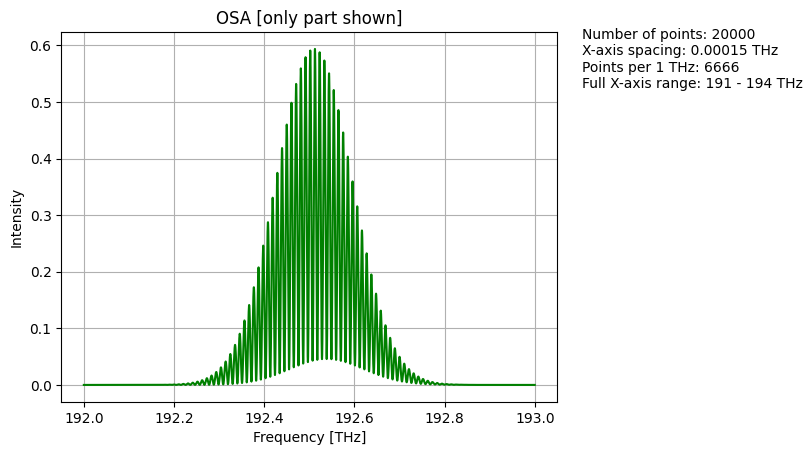

In [132]:
# prepare the pulse

def gaussian(omega, mu, sig):
    return np.exp(-np.power(omega - mu, 2.) / (2 * np.power(sig, 2.)))

gaussian = np.vectorize(gaussian)

X = np.linspace(191,194,20000)
Y_0 = X*0
Y = gaussian(X, 192.5, 0.12)

Y = Y.astype(complex)
X = X.astype(complex)
Y_0 = Y_0.astype(complex)

vertical = pd.DataFrame(np.transpose(np.stack([X, Y])))
horizontal = pd.DataFrame(np.transpose(np.stack([X, Y_0])))
ray = light(vertical, horizontal)

# propagate through system

ray.polarizer(transmission_polar = "ver")

# chirping fiber
ray.chirp(polarization = "ver", fiber_length = 60)
ray.chirp(polarization = "hor", fiber_length = 60)
ray.delay(polarization = "ver", delay = 60)         

ray.rotate(np.pi*0.25)

# modulator
transmission_matrix = np.array([[0.43, 0.55],[0.07, 0.015]]) # modulates vertical polarization
ray.mix(transmission_matrix)
ray.delay(polarization = "ver", delay = 16)
ray.shear(0.017, polarization = "ver")

#delaying fiber
ray.chirp(polarization = "ver", fiber_length = 80)
ray.chirp(polarization = "hor", fiber_length = 80)
ray.delay(polarization = "ver", delay = 80)         

ray.rotate(np.pi/4)

ray.polarizer(transmission_polar = "ver")

spectrum = ray.measure(start = 192, end = 193)


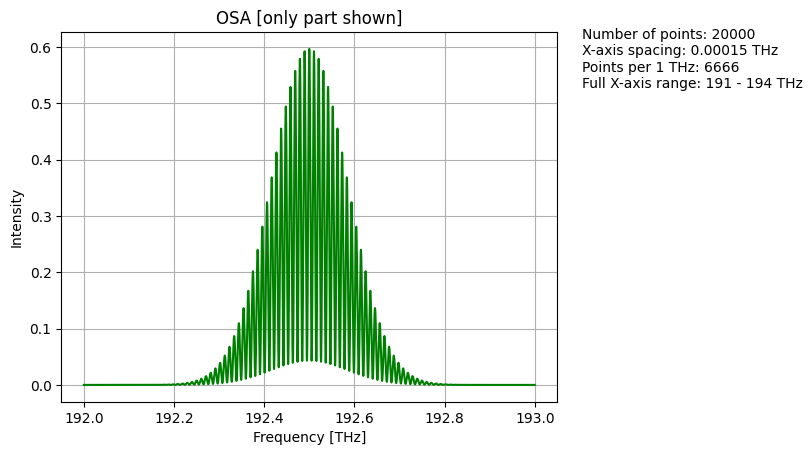

In [133]:
# prepare the pulse

def gaussian(omega, mu, sig):
    return np.exp(-np.power(omega - mu, 2.) / (2 * np.power(sig, 2.)))

gaussian = np.vectorize(gaussian)

X = np.linspace(191,194,20000)
Y_0 = X*0
Y = gaussian(X, 192.5, 0.12)

Y = Y.astype(complex)
X = X.astype(complex)
Y_0 = Y_0.astype(complex)

vertical = pd.DataFrame(np.transpose(np.stack([X, Y])))
horizontal = pd.DataFrame(np.transpose(np.stack([X, Y_0])))
ray = light(vertical, horizontal)

# propagate through system

ray.polarizer(transmission_polar = "ver")

# chirping fiber
ray.chirp(polarization = "ver", fiber_length = 60)
ray.chirp(polarization = "hor", fiber_length = 60)
ray.delay(polarization = "ver", delay = 60)         

ray.rotate(np.pi*0.25)

# modulator
transmission_matrix = np.array([[0.43, 0.55],[0.07, 0.015]]) # modulates vertical polarization
ray.mix(transmission_matrix)
ray.delay(polarization = "ver", delay = 16)
#ray.shear(0.017, polarization = "ver")

#delaying fiber
ray.chirp(polarization = "ver", fiber_length = 80)
ray.chirp(polarization = "hor", fiber_length = 80)
ray.delay(polarization = "ver", delay = 80)         

ray.rotate(np.pi/4)

ray.polarizer(transmission_polar = "ver")

temp_spectrum = ray.measure(start = 192, end = 193)

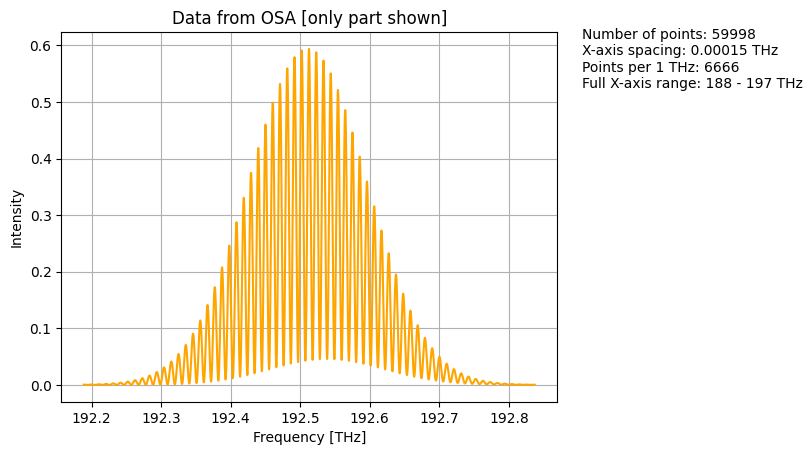

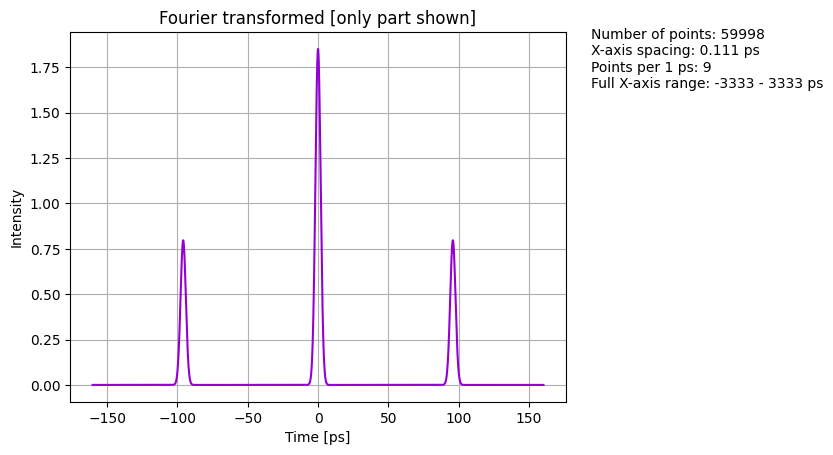

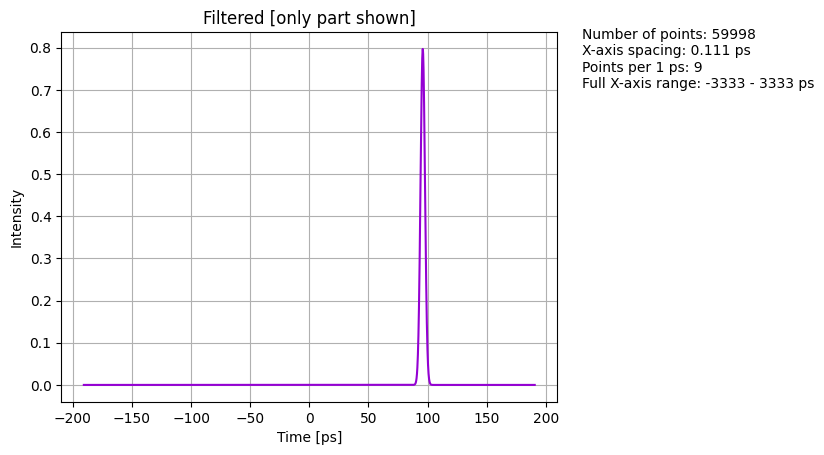

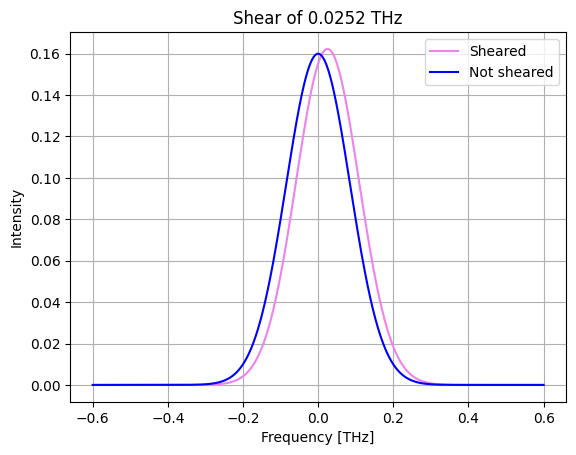

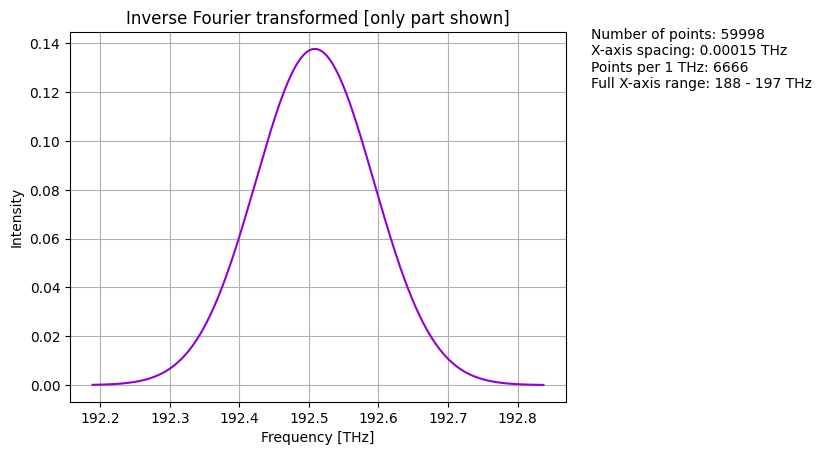

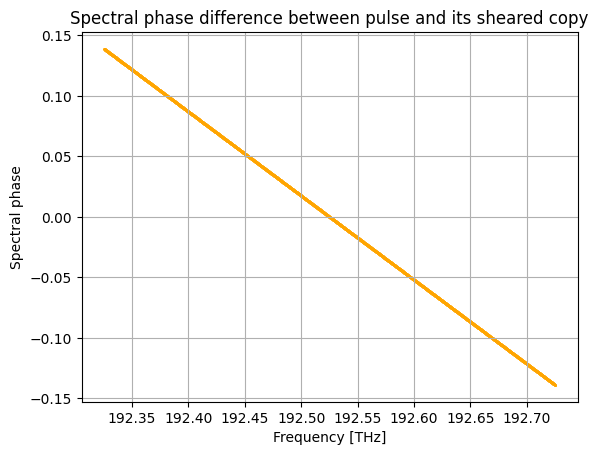

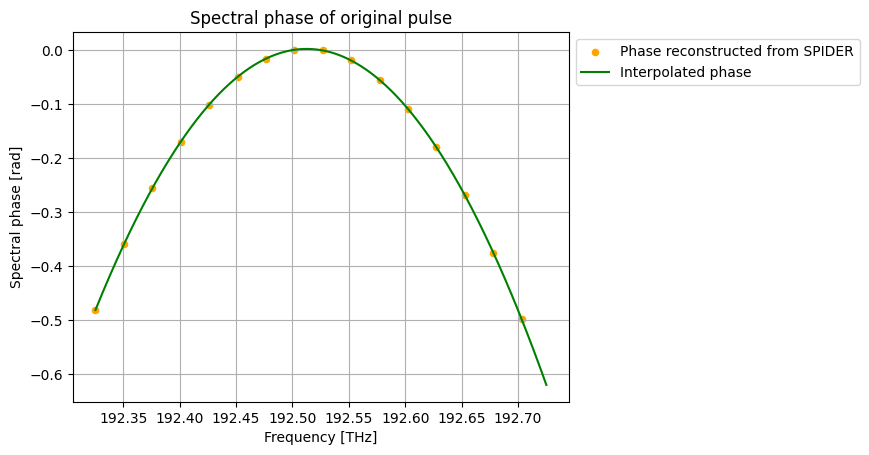

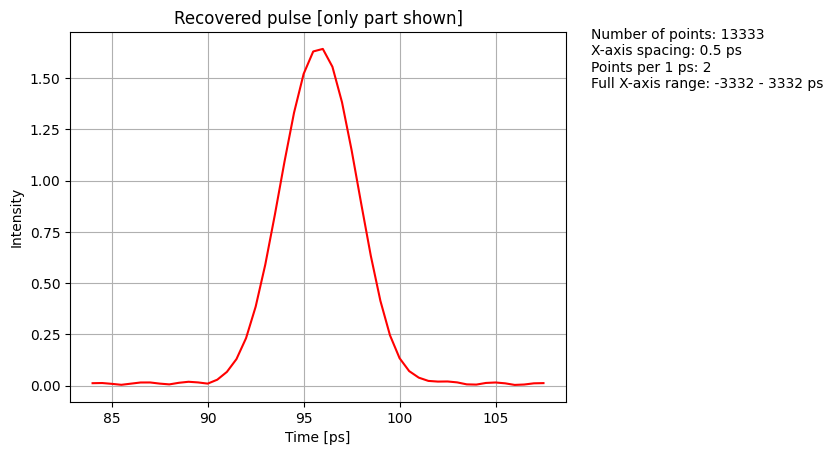

In [140]:
pulse = sa.spider(phase_spectrum = spectrum,
          temporal_spectrum = temp_spectrum,
          shear = None,
          spectrum_in = "freq",
          intensity_spectrum = None,
          phase_borders = [192.3, 192.7],
          what_to_return = "phase",
          vis_param = None,
          plot_steps = True,
          plot_phase = True,
          plot_pulse = True
          )[1]

pulse.values[:,1] *= -1

# comparison

C:\Users\rewas\AppData\Local\Temp\ipykernel_16564\2054684733.py:9: RuntimeWarning: overflow encountered in long_scalars
  return l_0**2*fiber_length*D_l/(4*np.pi*c)*(omega-omega_mean)**2


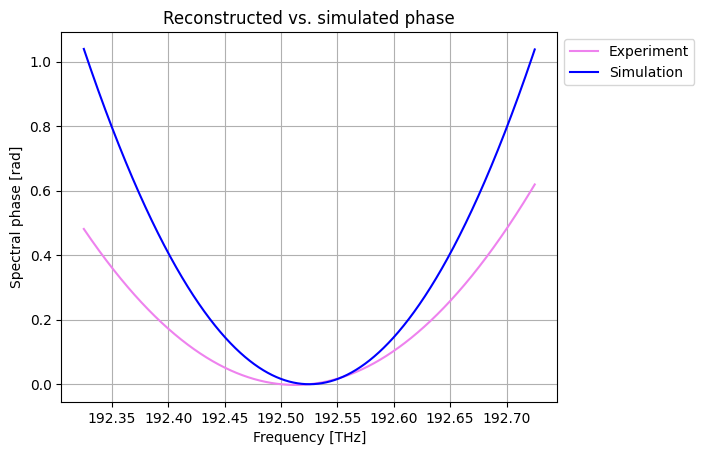

In [141]:
X = pulse.values[:, 0]

def phase(f, f_mean, fiber_length):
    l_0 = 1560
    c = 3*1e8
    D_l = 17
    omega = f*2*np.pi
    omega_mean = f_mean*2*np.pi
    return l_0**2*fiber_length*D_l/(4*np.pi*c)*(omega-omega_mean)**2

phase = np.vectorize(phase)

Y = phase(X, np.mean(X), 60)

sim_pulse = pd.DataFrame(np.transpose(np.stack([X, Y])))
sa.compare_plots([pulse, sim_pulse], title = "Reconstructed vs. simulated phase", legend = ["Experiment", "Simulation"], y_type = "phase")